In [1]:
from matplotlib import pyplot as plt
import b2plot as bp
#plt.style.use('belle2_modern')

# basic setup of the notebook

import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

For optimal usage set `plt.style.use('belle2')`
iminuit version: 2.15.2


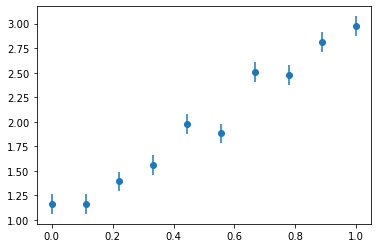

In [2]:
# our line model, unicode parameter names are supported :)
def line(x, α, β):
    return α + x * β


# generate random toy data with random offsets in y
np.random.seed(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1  # could also be an array
data_y = line(data_x, 1, 2) + data_yerr * np.random.randn(len(data_x))

# draw toy data
plt.errorbar(data_x, data_y, data_yerr, fmt="o");

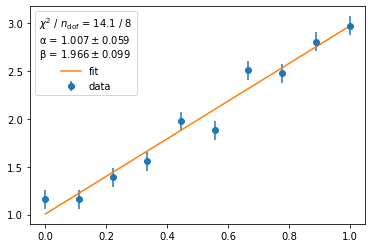

In [3]:
# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0, β=0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

# draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_x, line(data_x, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info));

In [4]:
import iminuit
from iminuit.cost import UnbinnedNLL
from iminuit import Minuit
import numpy as np
import numba as nb
import boost_histogram as bh
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba_stats import norm as norm_nb
print("iminuit version", iminuit.__version__)

iminuit version 2.15.2


In [5]:
rng = np.random.default_rng(1)

# conditional variable: each sample is paired with a random y parameter
y = rng.normal(0, 10, size=10000)
y = y[np.abs(y) < 10]  # truncate at 10

# location of each gaussian is a function of y
def mu(y, a, b):
    return a + b * y

# draw samples from Gaussians whose locations depend on y
truth = {"a": 0, "b": 0.5, "sigma": 1.0}
x = rng.normal(mu(y, truth["a"], truth["b"]), truth["sigma"])

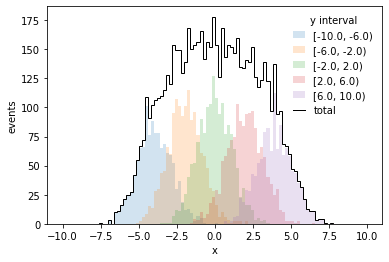

In [6]:
ax_x = bh.axis.Regular(100, -10, 10)
ax_y = bh.axis.Regular(5, -10, 10)
h = bh.Histogram(ax_x, ax_y)
h.fill(x, y)
for i, (a, b) in enumerate(ax_y):
    plt.stairs(h.values()[:,i], ax_x.edges, label=f"[{a}, {b})",
               fill=True, alpha=0.2)
h1 = h[:, sum]
plt.stairs(h1.values(), ax_x.edges, color="k", label="total")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(title="y interval", frameon=False, handlelength=1.2);

In [7]:
def model(xy, a, b, sigma):
    x, y = xy
    mu = a + b * y
    # cannot use norm.pdf from numba_stats here, because it is not vectorized in mu
    return norm.pdf(x, mu, sigma)

nll = UnbinnedNLL((x, y), model)

m = Minuit(nll, 0.0, 0.0, 2.0)
m.limits["sigma"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.93e+04                   │              Nfcn = 130              │
│ EDM = 2.25e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │  -0.010   │   0.012   │            │            │         │         │       │
│ 1 │ b     │  0.4993   │  0.0022   │            │            │         │         │       │
│ 2 │ sigma │   0.986   │   0.008   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        a        b    sigma │
├───────┼────────────────────────────┤
│     a │ 0.000142 1.31e-08 5.73e-08 │
│     b │ 1.31e-08 4.76e-06 1.02e-08 │
│ sigma │ 5.73e-08 1.02e-08 7.08e-05 │
└───────┴────────────────────────────┘

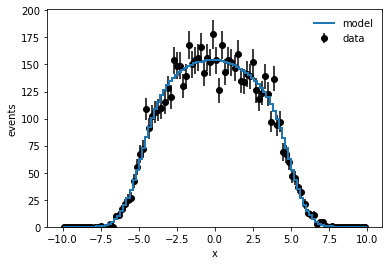

In [8]:
# construct model representation for comparison with data histogram
a, b, sigma = m.values

# get expected content per bin from cdf, sum over the individual cdfs
v = np.diff(np.sum(norm.cdf(ax_x.edges[:,np.newaxis],
                            mu(y, a, b), sigma), axis=1))

plt.stairs(v, ax_x.edges, label="model", zorder=5, lw=2)
plt.errorbar(ax_x.centers, h1.values(), h1.variances() ** 0.5,
             fmt="ok", label="data")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False);

In [9]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from iminuit.util import describe
from matplotlib import pyplot as plt
import numpy as np
from numba_stats import norm

In [10]:

# generate two data sets which are fitted simultaneously
rng = np.random.default_rng(1)

width = 2.0
data1 = rng.normal(0, width, size=1000)
data2 = rng.normal(5, width, size=1000)

In [11]:
# use two pdfs with different names for non-shared parameters,
# so that they are fitted independently

def pdf1(x, μ_1, σ):
    return norm.pdf(x, μ_1, σ)

def pdf2(x, μ_2, σ):
    return norm.pdf(x, μ_2, σ)

# combine two log-likelihood functions by adding them
lh = UnbinnedNLL(data1, pdf1) + UnbinnedNLL(data2, pdf2)

print(f"{describe(lh)=}")

describe(lh)=['μ_1', 'σ', 'μ_2']


In [12]:
def plot(cost, xe, minuit, ax, **style):
    signature = describe(cost)
    data = cost.data

    values = minuit.values[signature]
    errors = minuit.errors[signature]

    cx = (xe[1:] + xe[:-1]) / 2

    ym = np.diff(norm.cdf(xe, *values)) * np.sum(w)
    t = []
    for n, v, e in zip(signature, values, errors):
        t.append(f"${n} = {v:.3f} ± {e:.3f}$")
    ax.plot(cx, ym, label="\n".join(t), **style)

In [14]:
m = Minuit(lh, μ_1=1, μ_2=2, σ=1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

hists = [np.histogram(lhi.data, bins=50) for lhi in lh]

# draw data and model with initial parameters
for lhi, (w, xe), axi in zip(lh, hists, ax):
    cx = (xe[1:] + xe[:-1]) / 2
    axi.errorbar(cx, w, np.sqrt(w), fmt="ok", capsize=0, zorder=0)
    plot(lhi, xe, m, axi, ls="--")

m.migrad()

# draw model with fitted parameters
for lhi, (w, xe), axi in zip(lh, hists, ax):
    plot(lhi, xe, m, axi)
    axi.legend()

m.interactive()